## Load libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import time
import seaborn as sns
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report,precision_score,auc,accuracy_score, confusion_matrix, mean_squared_error
from sklearn import preprocessing

## Load Data

In [2]:
#Load time series with video
ts_video = pd.read_csv('timeseries_videos.csv')

## REMOVE DUPLICATES
ts_video = ts_video.drop_duplicates()
ts_video.head(1)

,video_id,channel id,video_title,owned views,day,category
0,I-QqU7uzFzw,UC3JF8FB_ihCGdIQdAnF0WLQ,Sonic The Hedgehog Trailer Reaction | Reaction...,2.0,20190527,film


In [3]:
#Load video metadata
md_video = pd.read_csv('video_metadata.csv')
md_video.head(1)

,video_id,publishedAt,tags,defaultAudioLanguage,duration,definition,licensedContent,relevantTopicIds
0,vNMs6q3x10Y,2019-04-16T11:22:27.000Z,BoybandPH sings|ABS-CBN Philippines|Showbiz|Pi...,NaN,PT4M13S,hd,False,/m/04rlf|/m/064t9


In [4]:
#Load video metadata
md_channel = pd.read_csv('channel_metadata.csv')
md_channel.head(1)

,channel_id,channel_title,channel_published_at,country,channel_topicIds
0,UCSqlOW3cdLtgq7W68M0QSeQ,KPOPVIRALZ,2015-02-06T08:42:46.000Z,US,/m/04rlf|/m/028sqc|/m/02jjt|/m/04rlf|/m/028sqc...


### Load topics data

In [5]:
topics = pd.read_csv('topicids.csv')
topics.head()

,id,topic
0,/m/04rlf,Music
1,/m/02mscn,Christian music
2,/m/0ggq0m,Classical music
3,/m/01lyv,Country
4,/m/02lkt,Electronic music


#### Merge video and channel data

In [6]:
add_md_video   = pd.merge(ts_video, md_video, on='video_id', how='left')
add_md_channel = pd.merge(add_md_video, md_channel, left_on='channel id', right_on='channel_id', how='left')
df = add_md_channel
df.head(1)

,video_id,channel id,video_title,owned views,day,category,publishedAt,tags,defaultAudioLanguage,duration,definition,licensedContent,relevantTopicIds,channel_id,channel_title,channel_published_at,country,channel_topicIds
0,I-QqU7uzFzw,UC3JF8FB_ihCGdIQdAnF0WLQ,Sonic The Hedgehog Trailer Reaction | Reaction...,2.0,20190527,film,2019-04-30T18:28:47.000Z,Sonic the Hedgehog Movie Trailer reaction|Soni...,en-US,PT2M51S,hd,False,/m/02jjt|/m/02vxn,UC3JF8FB_ihCGdIQdAnF0WLQ,Trailer Reaction,2018-10-10T19:05:53.000Z,ID,/m/02jjt|/m/02vxn|/m/04rlf|/m/0bzvm2|/m/02jjt|...


# Data Cleaning & Feature Engineering

##### Create feature with tags count

In [7]:
df['Tags_count']=df['tags'].fillna('').str.split("|").apply(lambda x: len(x))

##### Create feature with video duration (in seconds)

In [8]:
## Trim 2 first characters
df['trim_duration']=df['duration'].apply(lambda x: str(x)[2:])

## Replace nan with 0 seconds
df['trim_duration'].replace('n', '0S',inplace=True)

## Create function to deal with duration format and convert it to seconds
HMS_REGEX = re.compile('^(\d+)H(\d+)M(\d+)S$')
HS_REGEX = re.compile('^(\d+)H(\d+)S$')
MS_REGEX = re.compile('^(\d+)M(\d+)S$')
M_REGEX = re.compile('^(\d+)M$')
S_REGEX = re.compile('^(\d+)S$')


def total_seconds(hms_string):
    found = HMS_REGEX.match(hms_string)
    if found:
        x = found.group(1)
        return 3600 * int(found.group(1)) + \
               60 * int(found.group(2)) + \
               int(found.group(3))
            
    found = HS_REGEX.match(hms_string)
    if found:
        x = found.group(1)
        return 3600 * int(found.group(1)) + \
               int(found.group(2))        

    found = MS_REGEX.match(hms_string)
    if found:
        return 60 * int(found.group(1)) + int(found.group(2))
    
    found = M_REGEX.match(hms_string)
    if found:
        return 60 * int(found.group(1)) 
    
    found = S_REGEX.match(hms_string)
    if found:
        return int(found.group(1))

    raise ValueError('Could not convert ' + hms_string)

# Create feature with Duration in sec
df['Duration_Seconds'] = df['trim_duration'].apply(lambda x: total_seconds(str(x))) 

#### Create features for video & channel age (in days)

In [9]:
## Convert day to datetime
df['day'] = df['day'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

## Convert publishedAt to datetime
df['publishedAt']=df['publishedAt'].apply(lambda x: pd.to_datetime(str(x), format="%Y-%m-%dT%H:%M:%S.%fZ"))

## Convert channel_published_at to datetime
df['channel_published_at']=df['channel_published_at'].apply(lambda x: pd.to_datetime(str(x), format="%Y-%m-%dT%H:%M:%S.%fZ"))

## Create features
df['video_age'] = (df['day'] - df['publishedAt']).astype('timedelta64[D]')
df['channel_age'] = (df['day'] - df['channel_published_at']).astype('timedelta64[D]')
df.head(1)

,video_id,channel id,video_title,owned views,day,category,publishedAt,tags,defaultAudioLanguage,duration,...,channel_id,channel_title,channel_published_at,country,channel_topicIds,Tags_count,trim_duration,Duration_Seconds,video_age,channel_age
0,I-QqU7uzFzw,UC3JF8FB_ihCGdIQdAnF0WLQ,Sonic The Hedgehog Trailer Reaction | Reaction...,2.0,2019-05-27,film,2019-04-30 18:28:47,Sonic the Hedgehog Movie Trailer reaction|Soni...,en-US,PT2M51S,...,UC3JF8FB_ihCGdIQdAnF0WLQ,Trailer Reaction,2018-10-10 19:05:53,ID,/m/02jjt|/m/02vxn|/m/04rlf|/m/0bzvm2|/m/02jjt|...,11,2M51S,171,26.0,228.0


In [10]:
df['channel_age'].describe()  
#### -1 values are due to time difference in datetime. They are basically the same day so we set to 0 later below

count    193369.000000
mean       1680.177852
std        1122.938117
min          -1.000000
25%         820.000000
50%        1434.000000
75%        2479.000000
max        4994.000000
Name: channel_age, dtype: float64

In [11]:
df['video_age'].describe()  
#### -1 values are due to time difference in datetime. They are basically the same day so we set to 0 later below
#### Values <-1 are wrong input in data so we replace with column mean

count    177530.000000
mean        155.305284
std         430.012563
min          -5.000000
25%          12.000000
50%          30.000000
75%          71.000000
max        4654.000000
Name: video_age, dtype: float64

In [12]:
# Replace negative video ages
df['video_age'].replace(-1, 0,inplace=True)
df.loc[df['video_age'] < 0, 'video_age'] = df['video_age'].mean()
# Replace negative channel ages
df['channel_age'].replace(-1, 0,inplace=True)

#### Create binary features with 5 most frequent topics (combining channel & video topics)

In [13]:
## Concatenate strings with topic info 
df['TopicIds'] = df['relevantTopicIds'] +'|'+df['channel_topicIds']

## Split and count topics
Freq=df['TopicIds'].str.split('|', expand=True).stack().value_counts()

##Print top 5
Freq.head(5)

/m/04rlf     383722
/m/02jjt     191001
/m/064t9     131436
/m/019_rr     70904
/m/02vxn      67234
dtype: int64

In [14]:
## create columns for top 5 topics with 0 initial value
l=['/m/04rlf','/m/02jjt','/m/064t9','/m/019_rr','/m/02vxn']

for x in l:
    df[x]=0
    
## fill missing values
df['TopicIds']=df['TopicIds'].fillna('NoTopic')


## The below loop puts true/false values in the columns we created above 
## by searching the column name in the concatenated string with the topics
for y in l:
    df[y]=df['TopicIds'].apply(lambda x: y in x)

In [15]:
## Pick only needed features and drop the rest
data = df[['owned views','definition','category','licensedContent',
          'country','Tags_count','Duration_Seconds',
          'video_age','channel_age','/m/04rlf','/m/02jjt',
          '/m/064t9','/m/019_rr','/m/02vxn']]

data.head()

,owned views,definition,category,licensedContent,country,Tags_count,Duration_Seconds,video_age,channel_age,/m/04rlf,/m/02jjt,/m/064t9,/m/019_rr,/m/02vxn
0,2.0,hd,film,False,ID,11,171,26.0,228.0,True,True,False,False,True
1,12.0,hd,film,False,ID,11,171,6.0,208.0,True,True,False,False,True
2,80.0,hd,film,False,ID,11,171,0.0,202.0,True,True,False,False,True
3,3.0,hd,film,False,ID,11,171,20.0,222.0,True,True,False,False,True
4,83.0,hd,film,False,ID,11,171,2.0,204.0,True,True,False,False,True


## EDA

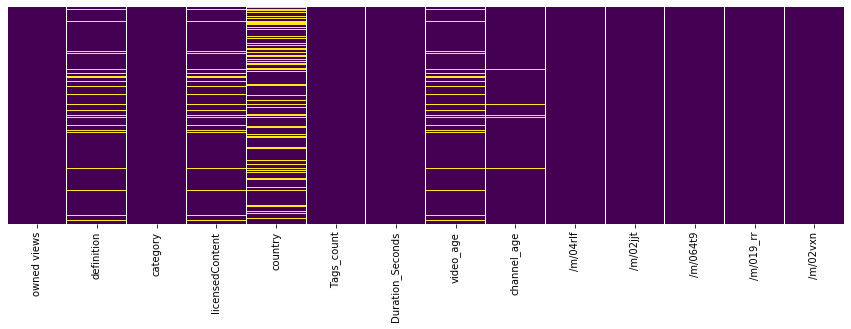

In [16]:
plt.figure(figsize=(15,4)) 
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
## We see a lot of missing values in 'definition', 'licensedContent', 'country', 'video_age' and 'channel_age'
## We will treat them later by filling the missing values

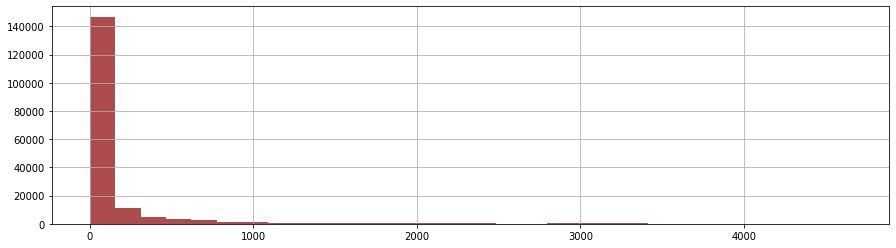

In [17]:
plt.figure(figsize=(15,4)) 
data['video_age'].hist(bins=30,color='darkred',alpha=0.7)

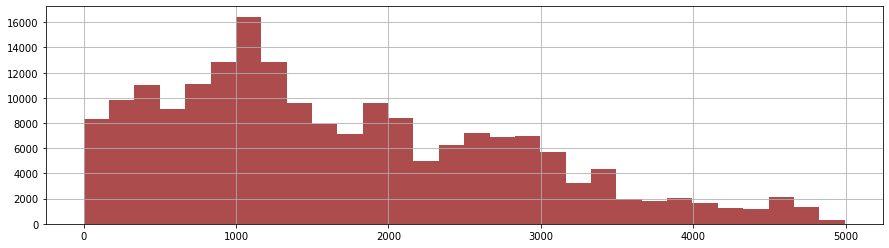

In [18]:
plt.figure(figsize=(15,4)) 
data['channel_age'].hist(bins=30,color='darkred',alpha=0.7)

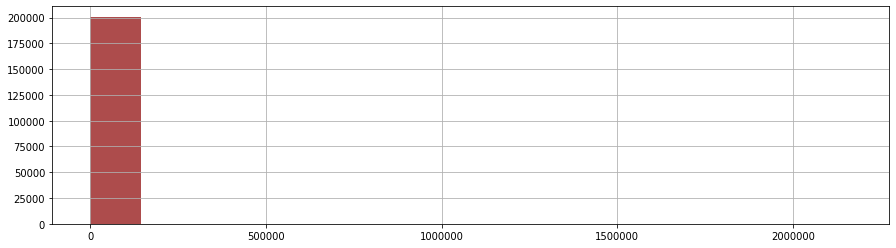

In [19]:
plt.figure(figsize=(15,4))
data['owned views'].hist(bins=15,color='darkred',alpha=0.7)

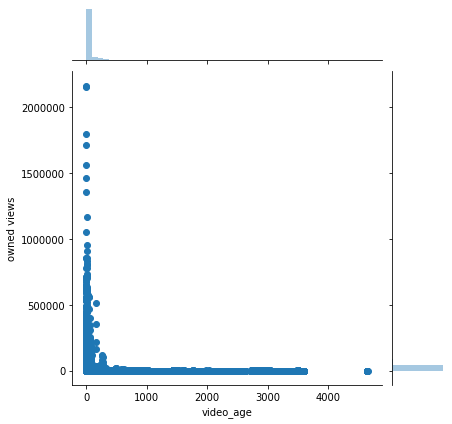

In [20]:
sns.jointplot(y='owned views',x='video_age',data=data)

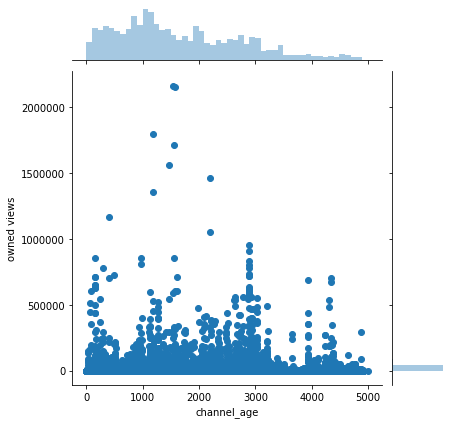

In [21]:
sns.jointplot(y='owned views',x='channel_age',data=data)

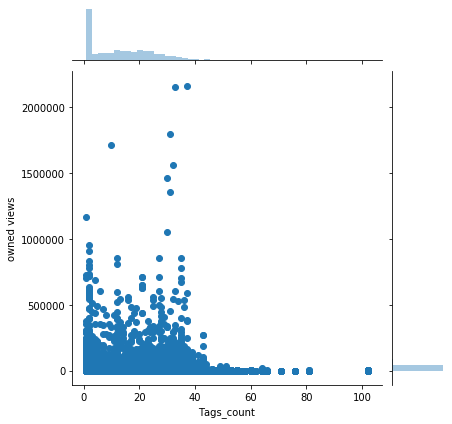

In [22]:
sns.jointplot(y='owned views',x='Tags_count',data=data)

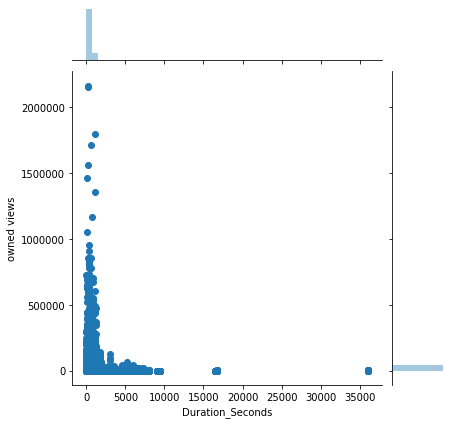

In [23]:
sns.jointplot(y='owned views',x='Duration_Seconds',data=data)

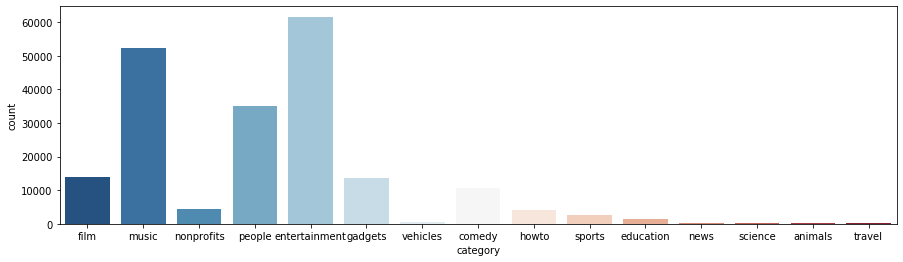

In [24]:
plt.figure(figsize=(15,4)) 
sns.countplot(x='category',data=data,palette='RdBu_r')

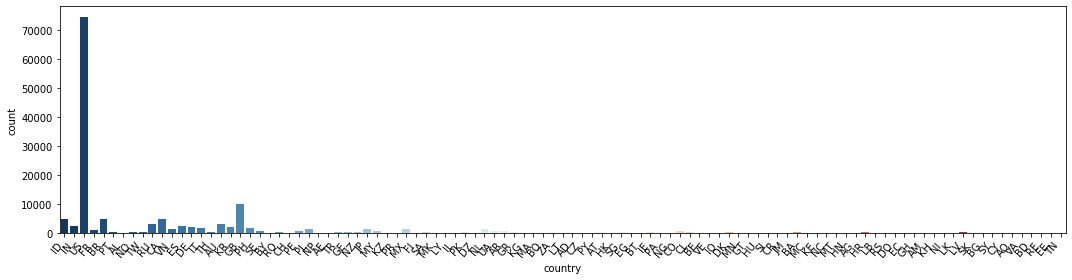

In [25]:
plt.figure(figsize=(15,4)) 
ax = sns.countplot(x='country',data=data,palette='RdBu_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.tight_layout()

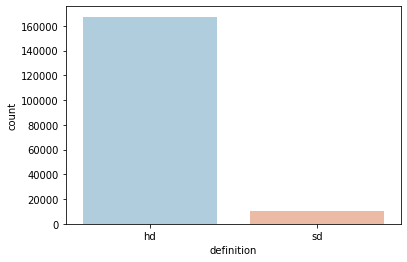

In [26]:
sns.countplot(x='definition',data=data,palette='RdBu_r')

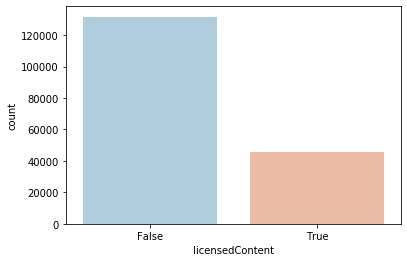

In [27]:
sns.countplot(x='licensedContent',data=data,palette='RdBu_r')

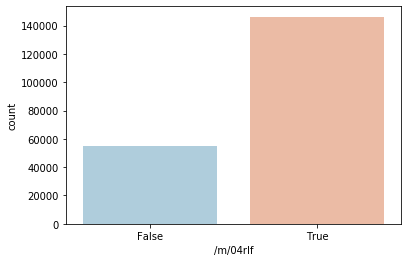

In [28]:
sns.countplot(x='/m/04rlf',data=data,palette='RdBu_r') 

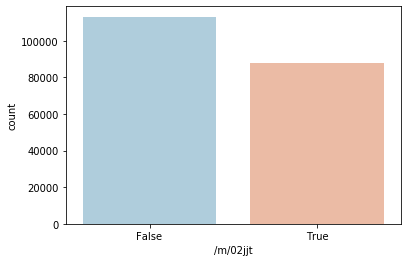

In [29]:
sns.countplot(x='/m/02jjt',data=data,palette='RdBu_r')

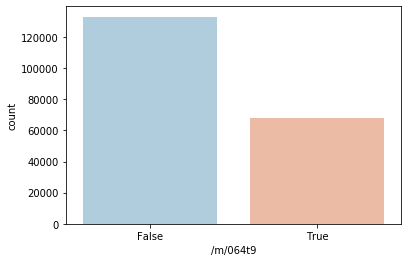

In [30]:
sns.countplot(x='/m/064t9',data=data,palette='RdBu_r') 

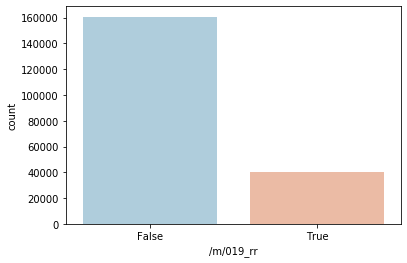

In [31]:
sns.countplot(x='/m/019_rr',data=data,palette='RdBu_r')

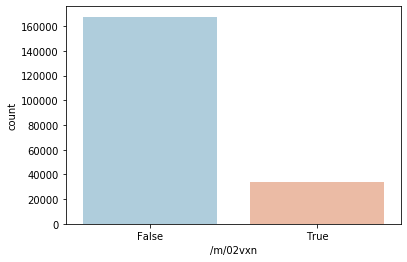

In [32]:
sns.countplot(x='/m/02vxn',data=data,palette='RdBu_r') 

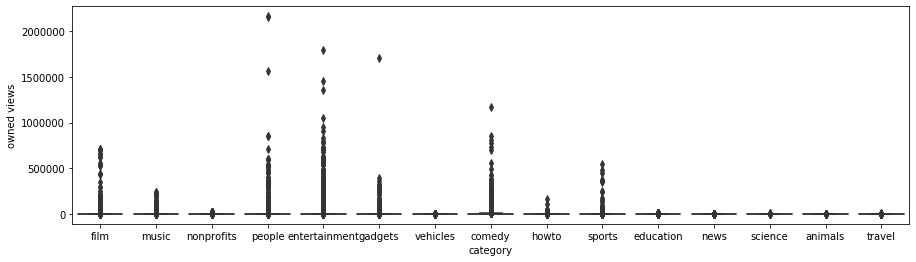

In [33]:
plt.figure(figsize=(15, 4))
sns.boxplot(x='category',y='owned views',data=data,palette='winter')

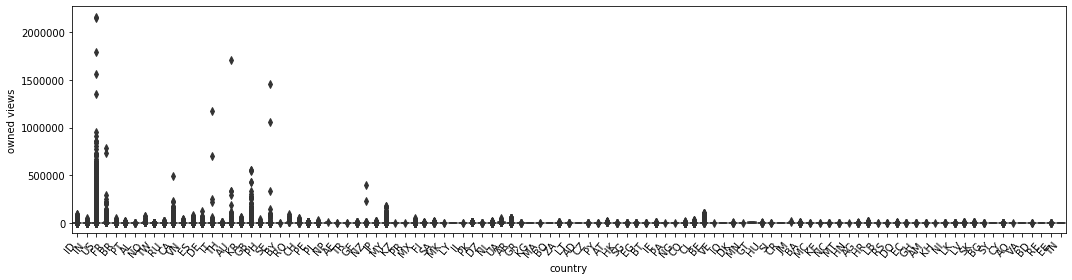

In [34]:
plt.figure(figsize=(15, 4))
ax=sns.boxplot(x='country',y='owned views',data=data,palette='winter')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.tight_layout()

## Issues in the data
  1. Missing values
  2. Categorical features with a lot of categories but few observations for some of these categories
  3. Outliers-Videos with more than 1M views (see boxplot above)

### Missing values treatment

In [35]:
## We fill the missing values in age columns with the mean of each column
data.loc[df['video_age'].isnull()==True, 'video_age'] = df['video_age'].mean()
data.loc[df['channel_age'].isnull()==True, 'channel_age'] = df['channel_age'].mean()

## Countries with no info
data.loc[df['country'].isnull()==True, 'country'] ='no_country'

## For licensedContent and definition columns we are using the most frequent data in the column in order to fill the missing info
## which is 'False' and 'hd' respectively 
data.loc[df['licensedContent'].isnull()==True, 'licensedContent'] =False
data.loc[df['definition'].isnull()==True, 'definition'] ='hd'

C:\Users\g.baras\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Reduce categories for categorical features

In [36]:
data['category'].value_counts(normalize=True)

entertainment    0.306198
music            0.259609
people           0.174713
film             0.069126
gadgets          0.067018
comedy           0.053455
nonprofits       0.022447
howto            0.020463
sports           0.012454
education        0.006453
vehicles         0.002854
travel           0.001780
science          0.001278
news             0.001163
animals          0.000989
Name: category, dtype: float64

In [37]:
## We see that all categories apart from entertainment,music & people are less than 7% of the total observations
## so we put them in a category called 'Other'

mapping = {
        'entertainment': 'entertainment',
        'music'        : 'music',
        'people'       : 'people',
        'film'         : 'Other',            
        'gadgets'      : 'Other',    
        'comedy'       : 'Other',    
        'nonprofits'   : 'Other',    
        'howto'        : 'Other',    
        'sports'       : 'Other',    
        'education'    : 'Other',    
        'vehicles'     : 'Other',    
        'travel'       : 'Other',    
        'science'      : 'Other',    
        'news'         : 'Other',    
        'animals'      : 'Other'  
        
        }

data['category']=data['category'].replace(mapping)
data['category'].value_counts(normalize=True)

C:\Users\g.baras\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


entertainment    0.306198
music            0.259609
Other            0.259480
people           0.174713
Name: category, dtype: float64

In [38]:
data['country'].value_counts(normalize=True)

US            0.370715
no_country    0.301908
GB            0.050457
ID            0.024426
BR            0.023486
CA            0.023292
AU            0.015879
RU            0.015536
IN            0.012688
ES            0.011639
KR            0.010326
DE            0.009869
PH            0.009058
IT            0.007945
NL            0.007617
MX            0.006965
JP            0.006911
VN            0.006756
PL            0.006503
FR            0.005961
AR            0.004067
MY            0.003923
CO            0.003535
SE            0.003505
PE            0.003351
UA            0.002645
TH            0.002526
ZA            0.002411
IE            0.002366
SA            0.002262
                ...   
NC            0.000273
NP            0.000249
NI            0.000229
MC            0.000219
VE            0.000209
SI            0.000194
GH            0.000194
BT            0.000169
AM            0.000149
BD            0.000149
NG            0.000129
BO            0.000104
MK         

In [39]:
## We see that all countries apart from US & no_country are less than 5% of the total observations
## so we put them in a category called 'Other'

data.loc[(data['country'] != 'US') & (data['country'] !='no_country'), 'country'] = 'Other'
data['country'].value_counts(normalize=True)

US            0.370715
Other         0.327377
no_country    0.301908
Name: country, dtype: float64

### Remove outliers

In [40]:
data=data[data['owned views']<1000000]
data['owned views'].describe()

count    201132.000000
mean       1748.873869
std       15678.504716
min           0.000000
25%           6.000000
50%          39.000000
75%         290.000000
max      951656.000000
Name: owned views, dtype: float64

## Encode Categorical Features

In [41]:
#define the list of categorical features for one hot encoding
cat_columns = ["definition", "category", "licensedContent", "country"]
data = pd.get_dummies(data, prefix_sep="__",
                             columns=cat_columns)
data.head()

,owned views,Tags_count,Duration_Seconds,video_age,channel_age,/m/04rlf,/m/02jjt,/m/064t9,/m/019_rr,/m/02vxn,...,definition__sd,category__Other,category__entertainment,category__music,category__people,licensedContent__False,licensedContent__True,country__Other,country__US,country__no_country
0,2.0,11,171,26.0,228.0,True,True,False,False,True,...,0,1,0,0,0,1,0,1,0,0
1,12.0,11,171,6.0,208.0,True,True,False,False,True,...,0,1,0,0,0,1,0,1,0,0
2,80.0,11,171,0.0,202.0,True,True,False,False,True,...,0,1,0,0,0,1,0,1,0,0
3,3.0,11,171,20.0,222.0,True,True,False,False,True,...,0,1,0,0,0,1,0,1,0,0
4,83.0,11,171,2.0,204.0,True,True,False,False,True,...,0,1,0,0,0,1,0,1,0,0


# Regression Model

In [42]:
## Train Test Split
X=data.loc[:, data.columns != 'owned views']
y=data.iloc[:,data.columns=='owned views']

data_dmatrix = xgboost.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [43]:
## XGBoost for regression
xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', 
                              colsample_bytree = 0.3, 
                              learning_rate = 0.1,
                              max_depth = 10, 
                              alpha = 10, 
                              n_estimators = 500)
training_start = time.perf_counter()
xg_reg.fit(X_train,y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xg_reg.predict(X_test)
prediction_end = time.perf_counter()
xgbR_train_time = training_end-training_start
xgbR_prediction_time = prediction_end-prediction_start
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("XGBRegressor's RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (xgbR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgbR_prediction_time))

XGBRegressor's RMSE is: 9905.52
Time consumed for training: 86.548 seconds
Time consumed for prediction: 2.50079 seconds


## k-fold Cross Validation

In [44]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10, 'n_estimators' : 500}

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

cv_results.describe()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
count,100.000000,100.000000,100.000000,100.000000
mean,9461.844203,848.766225,12086.495013,743.292537
std,2221.792209,182.128621,1206.975244,163.158782
min,6958.818197,485.727947,10844.263672,562.967458
25%,7654.194946,677.279903,11156.721110,642.723718
50%,8850.564535,869.886446,11704.192871,689.262183
75%,10591.062500,1000.384127,12634.277751,768.524756
max,15175.310873,1112.479473,15496.368490,1326.487250



### NOTES: 
-Despite the tuning the RMSE from the regression model is not acceptable since the 70% of the observations are between 0-200 views and the RMSE is 9900. 
-It is also very obvious from the EDA that 'owned views' doesn't have linear relationships with the features of the data set

## Below we will approach the problem as a classification problem by creating view classes


In [45]:
## Create classes for views
def viewClasses(x):
    if x<=10:      # '0-10'
        return 1 
    elif x<=50:    # '10-50'
        return 2 
    elif x<=200:   # '50-200'
        return 3  
    elif x<= 1000: # '200-1K'
        return 4
    elif x> 1000:  # '1K+'
        return 5
    
data['views_Class'] =  data['owned views'].apply(lambda x: viewClasses(x)) 
data['views_Class'].value_counts(normalize=True)

1    0.312054
2    0.223366
3    0.174363
4    0.153372
5    0.136845
Name: views_Class, dtype: float64

In [46]:
data=data.drop(['owned views'], axis=1)
data.head()

,Tags_count,Duration_Seconds,video_age,channel_age,/m/04rlf,/m/02jjt,/m/064t9,/m/019_rr,/m/02vxn,definition__hd,...,category__Other,category__entertainment,category__music,category__people,licensedContent__False,licensedContent__True,country__Other,country__US,country__no_country,views_Class
0,11,171,26.0,228.0,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,1
1,11,171,6.0,208.0,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,2
2,11,171,0.0,202.0,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,3
3,11,171,20.0,222.0,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,1
4,11,171,2.0,204.0,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,3


### Feature scaling

In [47]:
scaler = preprocessing.MinMaxScaler()
num_cols = ['Tags_count', 'Duration_Seconds', 'video_age','channel_age']
data[num_cols] = scaler.fit_transform(data[num_cols])
data.head()

,Tags_count,Duration_Seconds,video_age,channel_age,/m/04rlf,/m/02jjt,/m/064t9,/m/019_rr,/m/02vxn,definition__hd,...,category__Other,category__entertainment,category__music,category__people,licensedContent__False,licensedContent__True,country__Other,country__US,country__no_country,views_Class
0,0.09901,0.004749,0.005587,0.045655,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,1
1,0.09901,0.004749,0.001289,0.041650,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,2
2,0.09901,0.004749,0.000000,0.040449,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,3
3,0.09901,0.004749,0.004297,0.044453,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,1
4,0.09901,0.004749,0.000430,0.040849,True,True,False,False,True,1,...,1,0,0,0,1,0,1,0,0,3


### Train Test Split

In [48]:
X=data.drop(['views_Class'], axis=1)
y=data['views_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [49]:
## Weights for imbalanced classes
class_w = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

# Classification Models

## 1st Model - XGBoost Classifier

In [50]:
xgb = XGBClassifier(n_estimators=700,
                    objective='multi:softmax',
                    num_class=5,
                    max_depth=10,
                    learning_rate=0.1,
                    eta=0.1,
                    num_round = 20,
                    class_weight=class_w)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 81.27
Time consumed for training: 1279.243
Time consumed for prediction: 33890.52063 seconds


### XGBoost Classification Report

In [51]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.87      0.88      0.87     12564
           2       0.77      0.74      0.75      9090
           3       0.80      0.74      0.77      7003
           4       0.74      0.81      0.77      6097
           5       0.87      0.87      0.87      5473

    accuracy                           0.81     40227
   macro avg       0.81      0.81      0.81     40227
weighted avg       0.81      0.81      0.81     40227



### XGBoost Feature Importance

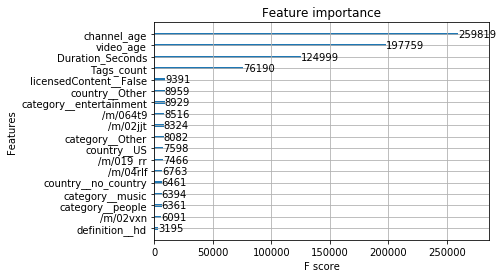

In [52]:
plot_importance(xgb)
pyplot.show()

### XGBoost Confusion Matrix

In [53]:
d = {'y_Predicted': preds,'y_Actual': y_test}

matrix = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(matrix['y_Actual'], matrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted      1     2     3     4     5
Actual                                  
1          11092   966    97   277   132
2           1377  6689   679   235   110
3            137   905  5209   636   116
4            137    86   525  4968   381
5             54    45    30   608  4736


## 2nd Model - Random Forest Classifier

In [54]:
rfc = RandomForestClassifier(n_estimators=50,class_weight='balanced')
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Random Forest Classifier's prediction accuracy is: 80.91
Time consumed for training: 10.853 seconds
Time consumed for prediction: 0.69267 seconds


### Random Forest Classification Report

In [55]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.88      0.86      0.87     12564
           2       0.78      0.73      0.75      9090
           3       0.77      0.76      0.77      7003
           4       0.72      0.81      0.77      6097
           5       0.85      0.87      0.86      5473

    accuracy                           0.81     40227
   macro avg       0.80      0.81      0.80     40227
weighted avg       0.81      0.81      0.81     40227



### Random Forest Feature Importance

Text(0.5, 0, 'Relative Importance')

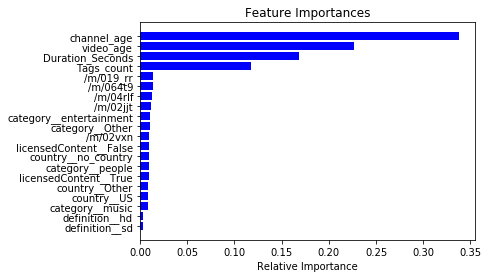

In [56]:
features=X_test.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

### Random Forest Confusion Matrix

In [57]:
d = {'y_Predicted': preds,'y_Actual': y_test}

matrix = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(matrix['y_Actual'], matrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted      1     2     3     4     5
Actual                                  
1          10866  1106   130   310   152
2           1237  6660   842   236   115
3             87   718  5329   747   122
4            113    64   512  4948   460
5             45    32    67   584  4745


## 3rd Model - K-Nearest Neighbor

#### Find optimal k

The optimal number of neighbors is 1


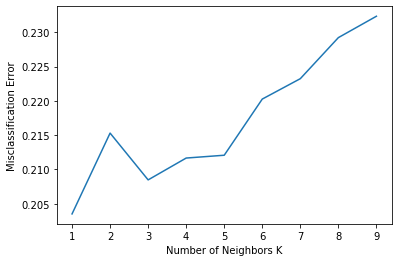

In [58]:
neighbors = list(range(1,10))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

#plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()    

In [59]:
knn = KNeighborsClassifier(n_neighbors=1)
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("KNN Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

KNN Classifier's prediction accuracy is: 79.69
Time consumed for training: 6.964 seconds
Time consumed for prediction: 20.33842 seconds


### KNN Classification Report

In [60]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.87      0.85      0.86     12564
           2       0.75      0.73      0.74      9090
           3       0.70      0.77      0.73      7003
           4       0.78      0.78      0.78      6097
           5       0.85      0.85      0.85      5473

    accuracy                           0.80     40227
   macro avg       0.79      0.79      0.79     40227
weighted avg       0.80      0.80      0.80     40227



### KNN Confusion Matrix

In [61]:
d = {'y_Predicted': preds,'y_Actual': y_test}

matrix = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(matrix['y_Actual'], matrix['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted      1     2     3     4     5
Actual                                  
1          10690  1223   312   183   156
2           1276  6604   936   141   133
3            119   794  5378   576   136
4             99   108   758  4727   405
5             74    48   268   424  4659


### Summary

In [63]:
results = pd.DataFrame({
                  'Model': ['XGBClassifier', 'Random Forest', 'KNN'],
                  'Accuracy': [acc_xgb, acc_rfc, acc_knn],
                  'Runtime Training': [xgb_train_time, rfc_train_time, knn_train_time],
                  'Runtime Prediction': [xgb_prediction_time, rfc_prediction_time,knn_prediction_time]})
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy,Runtime Training,Runtime Prediction
Model,,,
XGBClassifier,81.273771,1279.243311,33890.520634
Random Forest,80.910831,10.852980,0.692673
KNN,79.692744,6.964444,20.338416
